**Experiment 8**

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
data = stock_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Normalize the stock prices
data['Close'] = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())
data['Close']

<ipython-input-4-0f907beaf630>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())


,Close
Date,
2016-01-04,0.027982
2016-01-05,0.023060
2016-01-06,0.019313
2016-01-07,0.011390
2016-01-08,0.012341
...,...
2021-09-24,0.927147
2021-09-27,0.915588
2021-09-28,0.889788


In [ ]:
# Prepare the dataset function
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Previous 60 days

In [ ]:
# Parameters
time_step = 60  # Number of previous days to consider for prediction
X, y = create_dataset(data.values, time_step)

In [ ]:
# Reshape X for GRU input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the GRU model
model = keras.Sequential([
    layers.GRU(50, return_sequences=True, input_shape=(time_step, 1)),
    layers.GRU(50),
    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0129
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5006e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3503e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1282e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3977e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2424e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2334e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0496e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2761e-05
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2740e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1156e-05
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8377e-05
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.3687e-05
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6224e-05
Epoch 15/50
35/35 ━━━━━

In [ ]:
# Rescale the predictions back to original values
y_test_rescaled = y_test * (data['Close'].max() - data['Close'].min()) + data['Close'].min()
y_pred_rescaled = y_pred * (data['Close'].max() - data['Close'].min()) + data['Close'].min()

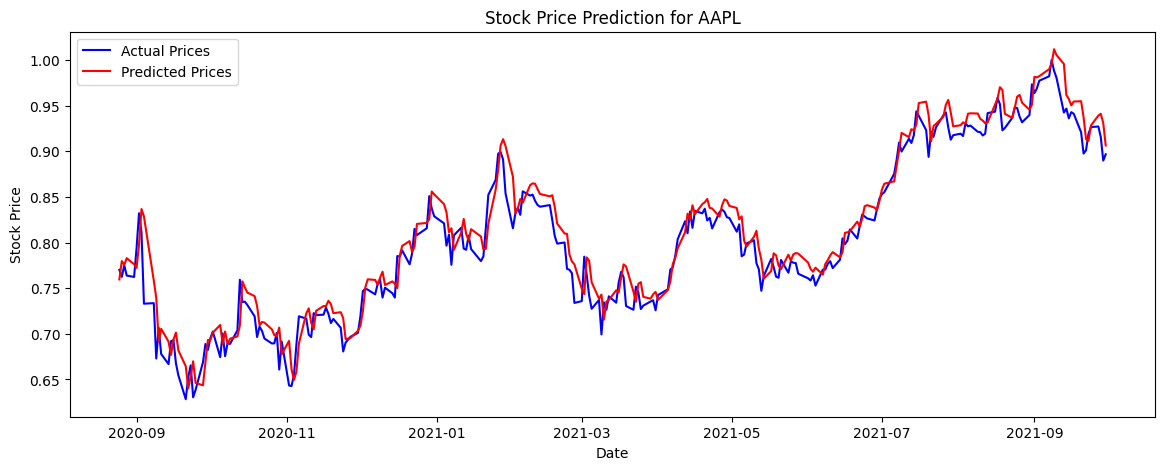

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + time_step + 1:], y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(data.index[train_size + time_step + 1:], y_pred_rescaled, color='red', label='Predicted Prices')
plt.title(f'Stock Price Prediction for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate the model
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)  # R-squared
# Prepare performance matrix
performance_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R²)'],
    'Value': [mse, mae, rmse, r2]
})

print(performance_matrix)

                           Metric     Value
0        Mean Squared Error (MSE)  0.000442
1       Mean Absolute Error (MAE)  0.016382
2  Root Mean Squared Error (RMSE)  0.021014
3                  R-squared (R²)  0.941692


# Previous 30 days

In [ ]:
# Parameters
time_step = 30  # Number of previous days to consider for prediction
X, y = create_dataset(data.values, time_step)

In [ ]:
# Reshape X for GRU input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the GRU model
model = keras.Sequential([
    layers.GRU(50, return_sequences=True, input_shape=(time_step, 1)),
    layers.GRU(50),
    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0118
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2549e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2064e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1748e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3627e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3928e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2527e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0593e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2415e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0972e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0298e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1805e-04
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7316e-05
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0618e-04
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━

In [ ]:
# Rescale the predictions back to original values
y_test_rescaled = y_test * (data['Close'].max() - data['Close'].min()) + data['Close'].min()
y_pred_rescaled = y_pred * (data['Close'].max() - data['Close'].min()) + data['Close'].min()

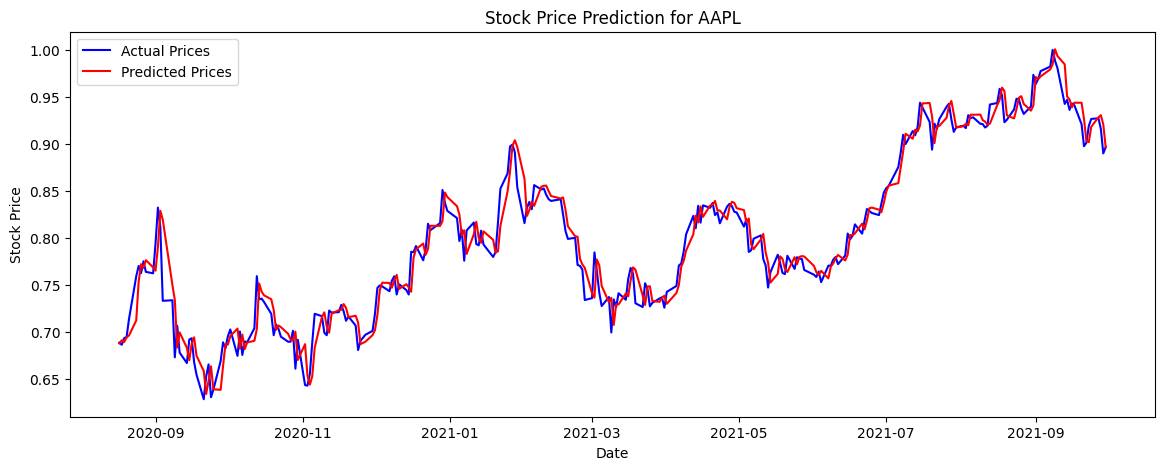

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + time_step + 1:], y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(data.index[train_size + time_step + 1:], y_pred_rescaled, color='red', label='Predicted Prices')
plt.title(f'Stock Price Prediction for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate the model
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)  # R-squared
# Prepare performance matrix
performance_matrix = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R²)'],
    'Value': [mse, mae, rmse, r2]
})
print(performance_matrix)

                           Metric     Value
0        Mean Squared Error (MSE)  0.000338
1       Mean Absolute Error (MAE)  0.013790
2  Root Mean Squared Error (RMSE)  0.018394
3                  R-squared (R²)  0.955566
